## This notebook demonstrates how to use ICESat-2 data in combination with a Sentinel-2 image to produce a satellite-derived bathymetry map.
### This is just an example - there are many ways to do this, and this is an introduction, not a master class.
### In this example, I am using a subset of a single Sentinel-2 image (to keep file sizes small and processing fast), I use only bands 2, 3 and 4 from the image, I use only the raw pixels values, and I use a Random Forest model. All of these choices could have been different, leading to different results.
### This example assumes that some pre-processing has been done, both for the ICESat-2 bathymetry data and for the Sentinel-2 image. As such, the input files need to be as follows:
- The ICESat-2 data must be in the form of a shapefile, with columns lon and lat indicating the location of each point, and column "elev" indicating the elevation of the seafloor relative to mean sea level (or another vertical reference).
- The Sentinel-2 image must be in the form of a multiband GeoTiff file. If you include more Sentinel-2 bands, you may need to resample them to 10-m spatial resolution before proceeding.

#### The data in this example come from Sanikiluaq, an archipelago in southern Hudson's Bay. In the image below you can see the ICESat-2 data points, colours coded by depth (red/yellow = shallow, blue/purple = deep), and the Sentinel-2 image in the background. Notice how the ICESat-2 data come in three lines - this will be important later.

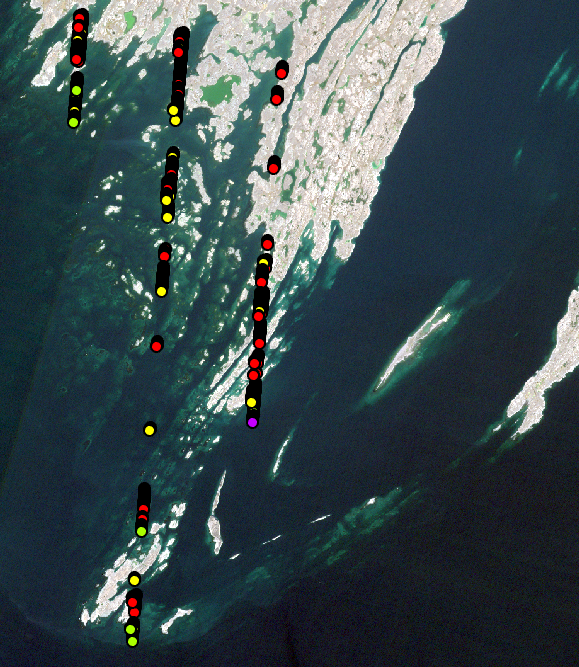

### 1) Install and import needed packages
#### Packages you may need and don't already have installed include:
- rasterio (for dealing with raster data), and
- geopandas (for dealing with spatial points), and
- sklearn and scipy for machine learning and statistics

In [1]:
import os

import numpy as np
import random

import rasterio
from rasterio.plot import show

import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd

from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')

### 2) Read the satellite image

In [2]:
# If you have not done so already, grad all the data files from this repository and place them in a folder.
# In this example I have the data in "C:/Users/aknud/Downloads/data/"

# Set the directory that holds your data
myDir = "C:/Users/aknud/Downloads/data/"  
os.chdir(myDir)

# Read image as rasterio dataset
image_filename = "S2_3bands.tif"  ### Update image filename here ###
image_ds = rasterio.open(image_filename)

#### Plot the image to check that it loaded alright - colours will look wrong but that's ok, we're just checking that the data got loaded properly

<Axes: >

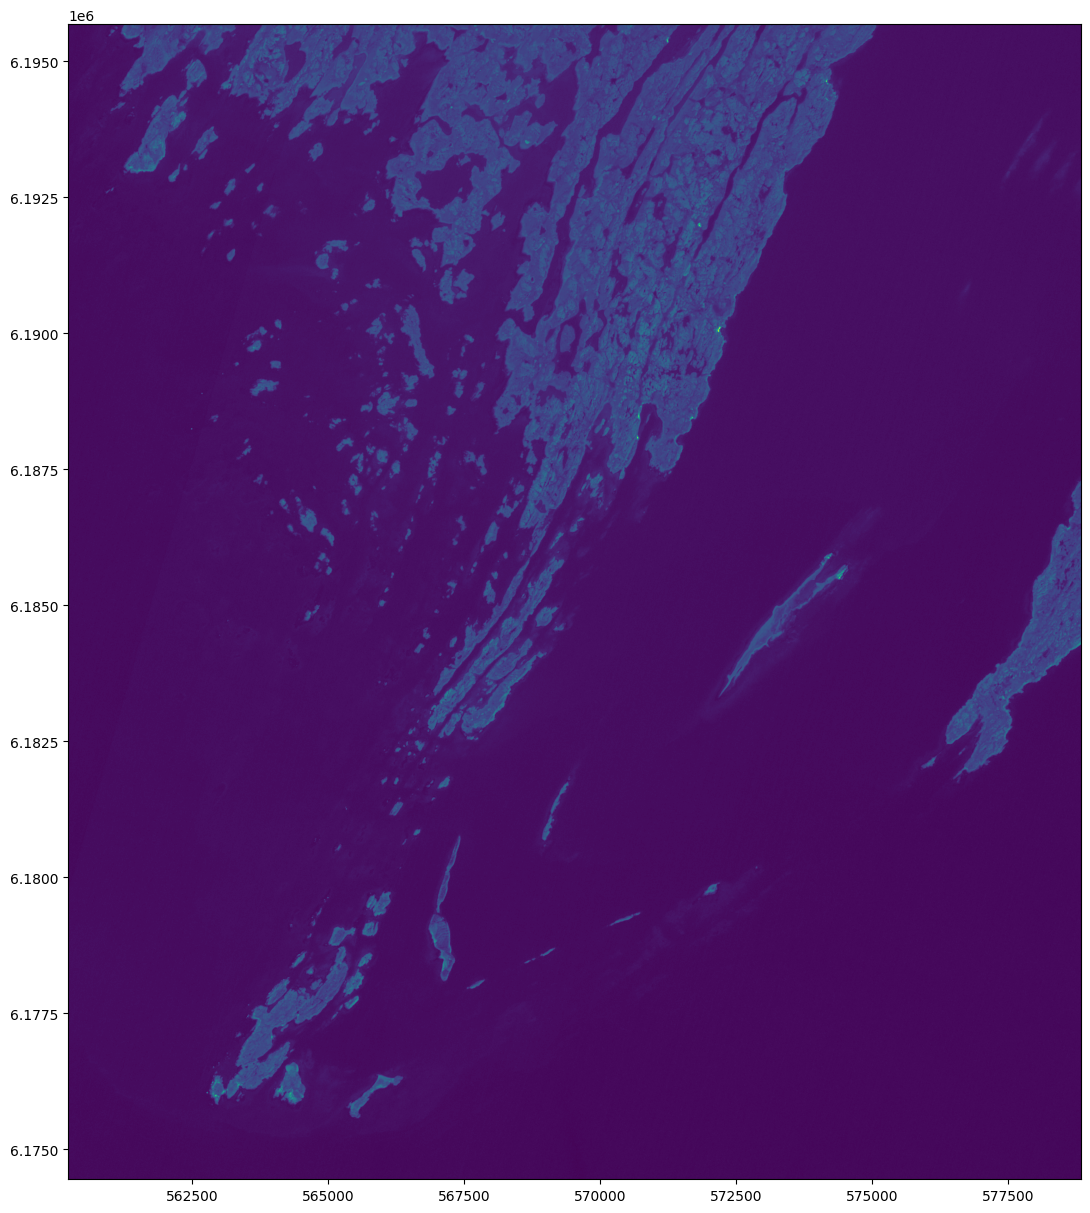

In [3]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
show(image_ds, ax=ax)

#### As mentioned above, this example uses bands 2, 3 and 4 from a Sentinel-2 image. However, rasterio thinks of those as band #1 (i.e. the first band it encounters in the file), band #2, and band #3. This can get a bit confusing. Here I name the variables that hold each band according to the original name of the band, i.e. I read the first band in the file as "b2".

In [4]:
# Read data from image bands into NumPy arrays
b2 = image_ds.read(1)
b3 = image_ds.read(2)
b4 = image_ds.read(3)

### 3) Load the point observations of depth from ICESat-2

In [5]:
# Read the shapefile containing the ICESat-2 data as a geopandas dataframe
depth_file = "bathypoints.shp"
df = gpd.read_file(depth_file) 

#### If the coordinate systems of the two datasets are not identical, reproject the points to match the coordinate system of the image

In [6]:
if df.crs != image_ds.crs:  # Check if the coordinate systems are the same
    df  = df.to_crs(image_ds.crs)  # If not, convert

In [7]:
# Check that the data frame makes sense. You'll see that it has the "elev" column that contains the bathymetry (negative elevations),
# the "lon" and "lat" columns, and the "geometry" information (using the coordinate systems of the Sentinel-2 image).
# The data also have a "line" that indicates, for each point, which of the three lines of ICESat-2 data it comes from.
print(df.head())

       elev        lon        lat  line                        geometry
0 -0.838104 -79.994234  55.898358     1  POINT (562890.760 6195224.255)
1 -0.925631 -79.994236  55.898345     1  POINT (562890.646 6195222.841)
2 -1.087278 -79.994240  55.898320     1  POINT (562890.419 6195220.014)
3 -1.165432 -79.994243  55.898307     1  POINT (562890.305 6195218.599)
4 -1.146102 -79.994248  55.898275     1  POINT (562890.021 6195215.063)


### 4) Sample the values in the image bands using the points from the shapefile

In [8]:
coords = [(x,y) for x, y in zip(df['geometry'].x, df['geometry'].y)]
df['b2'] = [x[0] for x in image_ds.sample(coords, indexes=1)]
df['b3'] = [x[0] for x in image_ds.sample(coords, indexes=2)]
df['b4'] = [x[0] for x in image_ds.sample(coords, indexes=3)]

In [9]:
# Check that columns have been added that contain the information from the imagery
print(df.head())

       elev        lon        lat  line                        geometry    b2  \
0 -0.838104 -79.994234  55.898358     1  POINT (562890.760 6195224.255)  1583   
1 -0.925631 -79.994236  55.898345     1  POINT (562890.646 6195222.841)  1583   
2 -1.087278 -79.994240  55.898320     1  POINT (562890.419 6195220.014)  1583   
3 -1.165432 -79.994243  55.898307     1  POINT (562890.305 6195218.599)  1443   
4 -1.146102 -79.994248  55.898275     1  POINT (562890.021 6195215.063)  1443   

     b3    b4  
0  1664  1658  
1  1664  1658  
2  1664  1658  
3  1501  1514  
4  1501  1514  


### 5) Do a bit of cleanup

#### Remove any points that fall outside the image. These will have values of 0 the b2, b3 and b4 columns. Also remove any points that have NoData in any of the bands.

In [10]:
# Remove any points outside the image (i.e. points with zero in all bands)
df = df.drop(df[(df['b2'] == 0.0) & (df['b3'] == 0.0) & (df['b4'] == 0.0)].index)

# And remove any points with NaN in any band
df.dropna()

elev        lon        lat  line                        geometry  \
0    -0.838104 -79.994234  55.898358     1  POINT (562890.760 6195224.255)   
1    -0.925631 -79.994236  55.898345     1  POINT (562890.646 6195222.841)   
2    -1.087278 -79.994240  55.898320     1  POINT (562890.419 6195220.014)   
3    -1.165432 -79.994243  55.898307     1  POINT (562890.305 6195218.599)   
4    -1.146102 -79.994248  55.898275     1  POINT (562890.021 6195215.063)   
...        ...        ...        ...   ...                             ...   
4162 -8.994288 -79.911637  55.787342     3  POINT (568249.589 6182947.778)   
4163 -9.047798 -79.911644  55.787304     3  POINT (568249.224 6182943.540)   
4164 -8.892638 -79.911657  55.787228     3  POINT (568248.492 6182935.063)   
4165 -8.628183 -79.911669  55.787164     3  POINT (568247.883 6182927.997)   
4166 -9.018587 -79.911719  55.786885     3  POINT (568245.234 6182896.895)   

        b2    b3    b4  
0     1583  1664  1658  
1     1583  1664  1658  
2     1583  1664  1658  
3     1443  1501  1514  
4     1443  1501  1514  
...    ...   ...   ...  
4162  1232  1231  1074  
4163  1232  1231  1074  
4164  1240  1228  1068  
4165  1259  1237  1086  
4166  1243  1244  1070  

[4167 rows x 8 columns]

#### Depending on the density of ICESat-2 points and the spatial resolution of the image (10 meters for Sentinel-2), you may end up with multiple points in each pixel. The code below checks for that, and creates a single point for any pixel that has multiple points in it, that new point having the mean 'elev' value of the original points.

In [11]:
# Add the coordinates for each point columns in the dataframe
df['x'] = df.geometry.x
df['y'] = df.geometry.y
df = df.drop('geometry', axis=1)

# Retain mean depth values when there are multiple points in each pixel
df = df.groupby(['b2', 'b3', 'b4']).mean().reset_index()

# Convert "line" back into integer
df['line'] = df['line'].astype(int)

print(df.head())

     b2    b3    b4       elev        lon        lat  line              x  \
0  1155  1159  1082 -10.322585 -79.966446  55.761648     2  564855.398604   
1  1158  1154  1070 -14.628153 -79.966457  55.761584     2  564854.786697   
2  1160  1167  1056 -12.650170 -79.963252  55.779844     2  565025.522534   
3  1161  1163  1090  -4.580924 -79.974713  55.723059     2  564400.186037   
4  1164  1137  1049 -11.569272 -79.963168  55.780299     2  565029.987127   

              y  
0  6.180036e+06  
1  6.180029e+06  
2  6.182064e+06  
3  6.175734e+06  
4  6.182114e+06  


### 6) Do SDB with Random Forest

#### Ok, now we're ready to make the Random Forest model, whose job it is to predict the value in the 'elev' column based on the values in the 'b2', 'b3' and 'b4' columns, i.e. to predict the depth of a pixel based on its colour.

#### To conduct a test of how good any model is at making predictions for new data - which is what we typically want models to be able to do - we need to make sure that we test the model against data that are "independent" from the data it is trained on.

#### "Independence" is a rather complex concept, and is probably better thought of as a relative than an absolute term. When working with spatial data, we can typically consider spatial proximity to be a good proxy for independence (closer data points being less independent from each other), so we want to make sure that the data used to train the model, and the data used to test the model, are as far away from each other as possible, within reason.

#### In this case, another approach is to use the three lines as groups of data, and consider them reasonably "independent" from one another. Of course they are still measured by the same instrument... To implement this idea, we will use the "line" column from the data and make sure we train the model on two of the lines, and then compare the model predictions to the data from the third line.

#### As with other choices made in this example, this is not the only way it could be done. But it serves its purpose for this example.

#### Create training and testing data. Here I use lines 1 and 3 to train the model, and line 2 for testing.

In [12]:
training = df.loc[df['line'].isin([1, 3])]
testing = df.loc[df['line'].isin([2])]

#### Train the Random Forest model.

#### A few notes:
- Any other type of predictive model could be used here.
- Normally you should optimize ("tune") model parameters for any machine learning model. Because this is a quick demonstration and parameter tuning can take a while, it is not included here.

In [13]:
# Here we will just use parameters that I have found to work well, generally

# Set model parameters
n_estimators = 30  # Use 30 "trees" in the "forest"
max_features = 'log2'  # Decide how many features are considered for each tree
criterion = "absolute_error"  # Set the loss function
columns = ["elev", "pred"]

# Calibrate the Random Forest model using the training data
X = np.dstack((training["b2"], training["b3"], training["b4"]))[0, :, :]
y = training["elev"]
reg = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, criterion=criterion)
reg.fit(X, y)

RandomForestRegressor(criterion='absolute_error', max_features='log2',
                      n_estimators=30)

#### Now use the trained model to make predictions for the testing data

In [14]:
newX = np.dstack((testing["b2"], testing["b3"], testing["b4"]))[0, :, :]
testing["pred"] = reg.predict(newX)

#### To see how good the model was at predicting the depths of the testing data using the image-derived pixel values, let's look at a scatter plot, and also calculate the correlation (R) and mean absolute error (MAE) values

Pearson's correlation: 0.87
MAE: 1.41


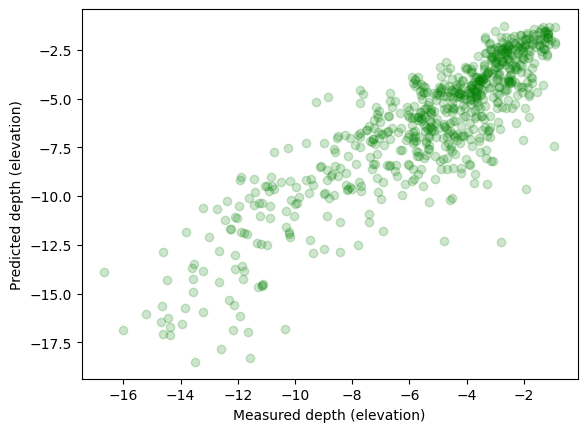

In [15]:
corr, _ = pearsonr(testing["pred"], testing["elev"])
print("Pearson's correlation: %.2f" % corr)

testing["error"] = testing["pred"] - testing["elev"]
testing["abs_error"] = np.abs(testing["error"])
mae_total = np.mean(testing["abs_error"])

print("MAE: %.2f" % mae_total)

plt.scatter(testing["elev"], testing["pred"], c="g", alpha=0.2)
plt.xlabel("Measured depth (elevation)")
plt.ylabel("Predicted depth (elevation)")
plt.show()

#### Because this kind of SDB only works where sunlight reflecting off the seafloor has a detectable influence on the signal measured by the satellite, the prediction errors generally increase with depth.
#### This is clear from the scatter plot above from the increased scatter along the regression line (not shown) as the depth increase towards the bottom left of the plot.
#### It therefore often makes sense to report not just one error value (such as the MAE value above), but to report the errors for different depths separately.

In [16]:
### Disaggregate error stats by depth range ###

# Determine min and max depth predictions for the testing data
min_depth = testing['pred'].min()
max_depth = testing['pred'].max()
min_depth_rounded = int(np.floor(min_depth))
max_depth_rounded = int(np.ceil(max_depth))

# Create some lists to hold results
mindepth = [] # This will hold the lower bound depth value of the interval
maxdepth = [] # Same, upper bound
mae = [] # MAE for the interval

for j in range(min_depth_rounded, max_depth_rounded, 1):  # Using 1-m depth intervals here
  
  df = testing[testing['pred'].between(j, j+1, inclusive='right')]
  errors = (df['elev'] - df['pred']).tolist()
  meanabserror = np.mean(np.abs(errors))
  mindepth.append(j)
  maxdepth.append(j+1)
  mae.append(meanabserror)

# Put all error results into a dataframe
errors_by_depth = pd.DataFrame(
    {'Min. Depth': mindepth,
     'Max. Depth': maxdepth,
     'MAE': mae
    })

print(errors_by_depth)

    Min. Depth  Max. Depth       MAE
0          -19         -18  5.880499
1          -18         -17  3.483550
2          -17         -16  3.085011
3          -16         -15  2.415523
4          -15         -14  2.222288
5          -14         -13  1.232664
6          -13         -12  3.209258
7          -12         -11  1.395140
8          -11         -10  1.922664
9          -10          -9  2.093750
10          -9          -8  2.415564
11          -8          -7  2.006760
12          -7          -6  1.605910
13          -6          -5  1.289738
14          -5          -4  1.106059
15          -4          -3  0.801328
16          -3          -2  0.518884
17          -2          -1  0.494708


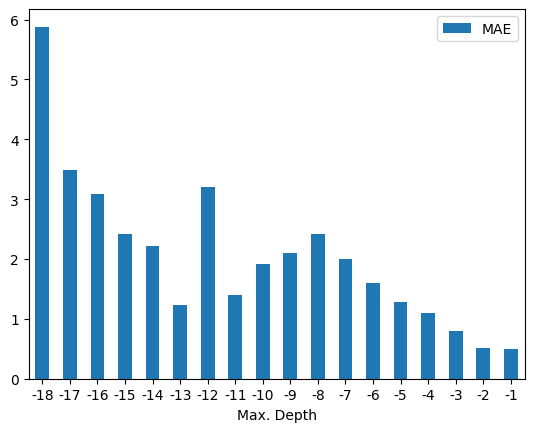

In [17]:
# Or show the errors on a bar plot
ax = errors_by_depth.plot.bar(x='Max. Depth', y='MAE', rot=0)

### 7) The final step is to use the model to make predictions for all pixels in the image

#### To work with predictions, we need to flatten the 2D image bands into 1D NumPy arrays, then pass them all through the model, and the "unflatten" them again to recreate the correct image geometry

In [18]:
# To work with predictions, we need to flatten the input arrays
# Because some images contain NoData values in the corners, we also turn those into zeros
b2_flat = np.nan_to_num(b2.flatten())
b3_flat = np.nan_to_num(b3.flatten())
b4_flat = np.nan_to_num(b4.flatten())

# Restructure the data to work with the "predict" function
newX = np.dstack((b2_flat, b3_flat, b4_flat))[0, :, :]

# Make the preditions for each pixel
new_predictions = reg.predict(newX)

# "Unflatten" the result
new_predictions_unflattened = new_predictions.reshape(b2.shape)

In [19]:
# Write predictions to file
predictions_filename = "SDB.tif"

with rasterio.Env():

    # Write an array as a raster band to a new file. For the new file's profile, we start with the profile of the source
    profile = image_ds.profile

    # Then set the dtype to contain floats, and specify LZW compression.
    profile.update(
        driver='GTiff',
        dtype=rasterio.float32,
        count=1,
        compress='lzw')

    with rasterio.open(predictions_filename, 'w', **profile) as dst:
        dst.write(new_predictions_unflattened.astype(rasterio.float32), 1)
        dst.set_band_description(1, 'SDB')

### 8) Important notes:

#### The code shown above makes SDB predictions of water depth for all pixels in the image. These predictions are not meaning for pixels on land, and neither are they meaningful for water that is optically deep, i.e. where sunlight reflected off the seafloor has a non-detectable influence on the colour of the pixel. It is therefore up to the user to mask out those pixels from the result.
#### Land pixels can often be masked out with a simple threshold applied to a near-infrared band. Optically deep pixels are more difficult to mask out, one way of doing this is to use the tool available here: https://github.com/yulunwu8/Optically-Shallow-Deep.
#### Finally, note that SDB predictions are just that - predictions. As shown above there are errors asociated with these predictions, and they should be used with appropriate caution. However, if you compare the SDB results (right side) with the image (left side), I trust you will conclude that the results are not too shabby for a quick demonstration!

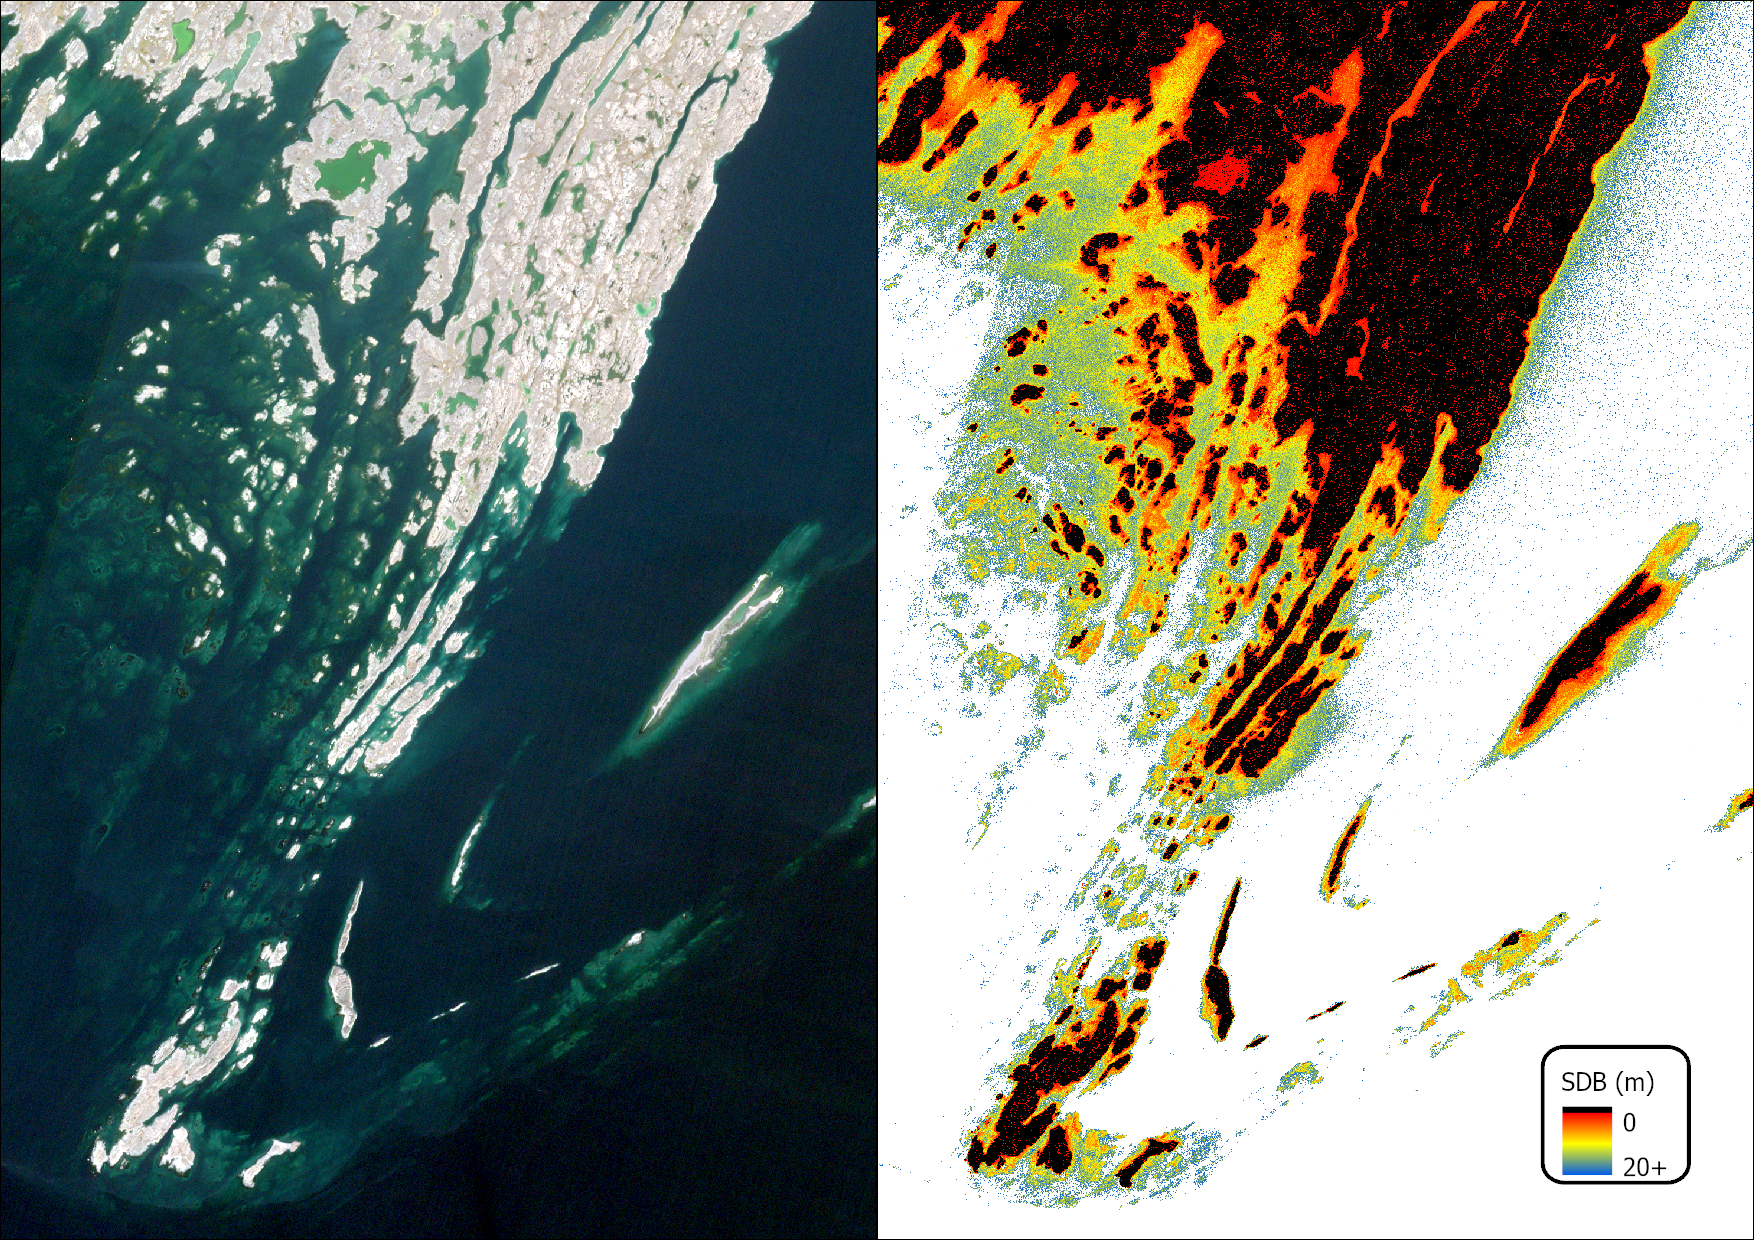